# NVIDIA Stock Movement Prediction  - Milestone 4

In [120]:
# Imports all the necessary packages
import polars as pl
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings

# Disables the warnings
warnings.filterwarnings('ignore')

### Importing the data

In [121]:
# Reads in the csv file
df = pl.read_csv("data/main/NVDA.csv", try_parse_dates=True)

# Sorts by date
df = df.sort(by=["Date"])
df.head()

Date,Open,High,Low,Close,Adj Close,Volume
date,f64,f64,f64,f64,f64,i64
2000-01-03,0.984375,0.992188,0.919271,0.97526,0.894608,30091200
2000-01-04,0.958333,0.960938,0.901042,0.949219,0.870721,30048000
2000-01-05,0.921875,0.9375,0.904948,0.917969,0.842055,18835200
2000-01-06,0.917969,0.917969,0.822917,0.858073,0.787112,12048000
2000-01-07,0.854167,0.88151,0.841146,0.872396,0.800251,7118400


### Checking for missing values

In [122]:
# Check for missing values
df.describe()

statistic,Date,Open,High,Low,Close,Adj Close,Volume
str,str,f64,f64,f64,f64,f64,f64
"""count""","""6116""",6116.0,6116.0,6116.0,6116.0,6116.0,6116.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2012-02-28 11:27:16.363000""",53.052266,54.017201,52.0317,53.064741,52.794253,6.2219e7
"""std""",null,121.267334,123.423982,118.835114,121.183234,121.214864,4.3167e7
"""min""","""2000-01-03""",0.608333,0.656667,0.6,0.614167,0.563377,4.5644e6
"""25%""","""2006-02-02""",2.96,3.0275,2.875,2.950521,2.708334,3.61608e7
"""50%""","""2012-02-29""",4.685,4.7475,4.61,4.6825,4.389289,5.20639e7
"""75%""","""2018-03-27""",42.099998,42.645,41.4925,42.099998,41.730057,7.46548e7
"""max""","""2024-04-24""",958.51001,974.0,935.099976,950.02002,950.02002,9.230856e8


> There are no missing values in our dataset.

### Data Preparation/Feature Engineering

In [123]:
# Create a lag shift column to show the previous day's closing price.
df = df.with_columns(prev_close = pl.col("Close").shift(1))



# Normalizing the Close and Volume columns.
# scaler = MinMaxScaler()
# df[['Close', 'Volume', 'prev_close']] = scaler.fit_transform(df[['Close', 'Volume', 'prev_close']])

# Creates a target column that shows if the stock price increased or decreased from the previous day.
df = df.with_columns(
    target = (pl.col("Close") > pl.col("prev_close")).cast(pl.Int8),
    moving_avg_5 = pl.col("Close").rolling_mean(window_size=5),
    moving_avg_20 = pl.col("Close").rolling_mean(window_size=20),
    moving_avg_100 = pl.col("Close").rolling_mean(window_size=100)
    )

# Removes records without a previous close price
df = df.drop_nulls()

# Selects the features and target columns
X = df.select("prev_close", "moving_avg_5", "moving_avg_20", "moving_avg_100")
y = df.select("target")

# Splits the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df.head()

Date,Open,High,Low,Close,Adj Close,Volume,prev_close,target,moving_avg_5,moving_avg_20,moving_avg_100
date,f64,f64,f64,f64,f64,i64,f64,i8,f64,f64,f64
2000-05-24,2.244792,2.28125,1.921875,2.21875,2.035264,73963200,2.247396,0,2.2010416,1.940495,1.510091
2000-05-25,2.251302,2.385417,2.160156,2.1875,2.006598,56918400,2.21875,0,2.209375,1.955078,1.522214
2000-05-26,2.198568,2.259115,2.0625,2.198568,2.016751,18345600,2.1875,1,2.2235678,1.972168,1.534707
2000-05-30,2.257813,2.346354,2.247396,2.289063,2.099762,30364800,2.198568,1,2.2282554,1.990788,1.548418
2000-05-31,2.28125,2.416667,2.28125,2.377604,2.180981,46953600,2.289063,1,2.254297,2.017546,1.5636133


In [124]:
# Check class distribution in the target variable
print("Class distribution in the target:")
print(y_train["target"].value_counts())


Class distribution in the target:
shape: (2, 2)
┌────────┬───────┐
│ target ┆ count │
│ ---    ┆ ---   │
│ i8     ┆ u32   │
╞════════╪═══════╡
│ 0      ┆ 2331  │
│ 1      ┆ 2482  │
└────────┴───────┘


### Logistic Regression

In [125]:
# Creates a logistic regression model
model = LogisticRegression()

# Fits the model
model.fit(X_train, y_train)

# Predicts the target values
y_pred = model.predict(X_test)


### Model Evaluation

Use common metrics to evaluate model performance

In [126]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')

Accuracy: 0.54
Precision: 0.53
Recall: 0.95
F1 Score: 0.68
ROC-AUC: 0.52


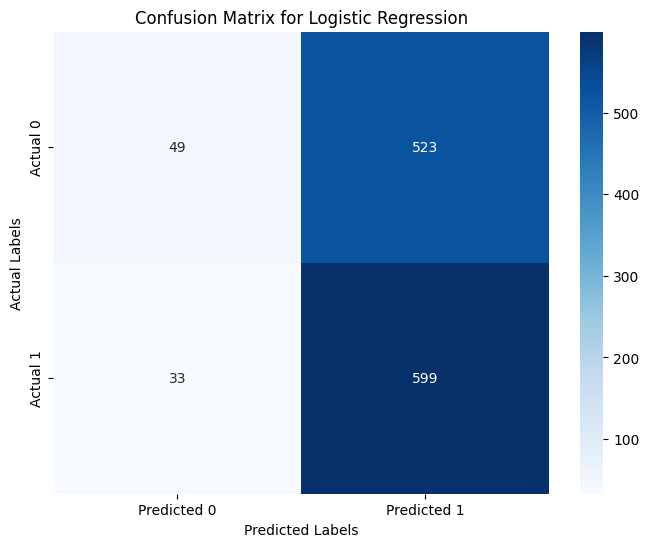

In [127]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define the labels for each quadrant of the matrix
labels = [
    ['True Negatives (TN)', 'False Positives (FP)'],
    ['False Negatives (FN)', 'True Positives (TP)']
]

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

# Add titles and labels
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()


> The accuracy of 0.54 suggests that it performs slightly better than random. Precision is 0.53, indicating moderate reliability when predicting positives. A recall of 0.95 reflects that the model successfully identifies all actual positives, likely at the cost of increased false positives. The F1 score of 0.68 represents a reasonable balance between precision and recall but could be improved. However, the ROC-AUC score of 0.52 suggests the model is currently no better than random in distinguishing between classes.

### Random Forest Model

In [128]:
# This is the grid search for the Random Forest Classifier to select the best n_estimators
param_grid = {'n_estimators': [50, 100, 150, 200, 250]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_n_estimators = grid_search.best_params_['n_estimators']
best_n_estimators

200

In [129]:
# Trains the Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_rf_pred = rf_model.predict(X_test)

# Evaluate Random Forest model
rf_accuracy = accuracy_score(y_test, y_rf_pred)
rf_precision = precision_score(y_test, y_rf_pred)
rf_recall = recall_score(y_test, y_rf_pred)
rf_f1 = f1_score(y_test, y_rf_pred)
rf_roc_auc = roc_auc_score(y_test, y_rf_pred)

# Print the evaluation metrics for Random Forest
print(f'Random Forest Accuracy: {rf_accuracy:.2f}')
print(f'Random Forest Precision: {rf_precision:.2f}')
print(f'Random Forest Recall: {rf_recall:.2f}')
print(f'Random Forest F1 Score: {rf_f1:.2f}')
print(f'Random Forest ROC-AUC: {rf_roc_auc:.2f}')

Random Forest Accuracy: 0.54
Random Forest Precision: 0.56
Random Forest Recall: 0.56
Random Forest F1 Score: 0.56
Random Forest ROC-AUC: 0.54


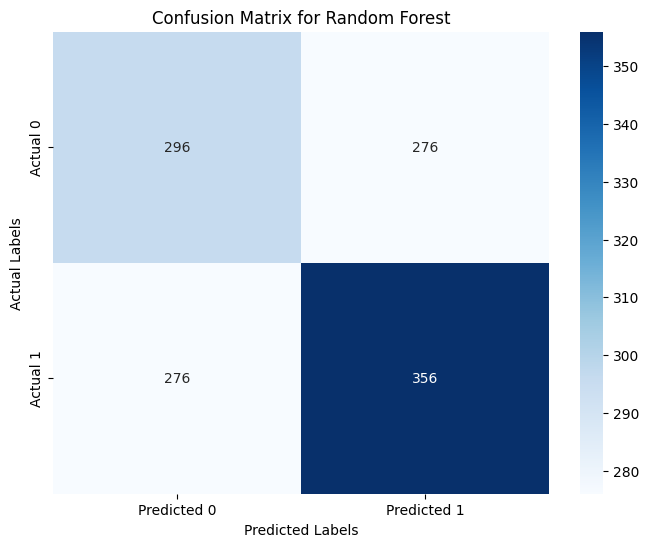

In [130]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_rf_pred)

# Define the labels for each quadrant of the matrix
labels = [
    ['True Negatives (TN)', 'False Positives (FP)'],
    ['False Negatives (FN)', 'True Positives (TP)']
]

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

# Add titles and labels
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

> With an accuracy of 0.51, the model is performing just above random chance, classifying only about half of the cases correctly. Precision and recall are similarly low at 0.52 and 0.53, suggesting that while it captures some true positives, it also misclassifies a comparable number of false positives. The F1 score of 0.53 reflects this imbalance, indicating limited trade-off between precision and recall. The ROC-AUC score, close to 0.51, shows minimal class separation, underscoring the model’s difficulty in distinguishing between classes.

### LSTM model

In [131]:
# Reshape the data to be compatible with LSTM input requirements.
X_lstm = np.array(X).reshape((X.shape[0], 1, X.shape[1]))

# Split the dataset into training and testing sets for LSTM.
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y, test_size=0.2, random_state=42)

# Build the LSTM model using the Sequential API.
lstm_model = Sequential()

# Add an LSTM layer with 50 units and define the input shape.
lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))

# Add a Dense layer with a sigmoid activation function for binary classification.
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model.
# Using the Adam optimizer for its adaptive learning rate capabilities, which helps achieve faster convergence and stability during training.
# Binary cross-entropy loss is chosen for binary classification, as it effectively measures the difference between the actual and predicted class probabilities.
# It works well with the sigmoid activation function used in the output layer.
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model on the training dataset.
# The model will be trained for 10 epochs with a batch size of 32 as a good starting point without overfitting.
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32)

# The predictions are thresholded at 0.5 to convert probabilities to binary class labels.
y_lstm_pred = (lstm_model.predict(X_test_lstm) > 0.5).astype("int32")

# Calculate evaluation metrics for the LSTM model's performance.
lstm_accuracy = accuracy_score(y_test_lstm, y_lstm_pred)
lstm_precision = precision_score(y_test_lstm, y_lstm_pred)
lstm_recall = recall_score(y_test_lstm, y_lstm_pred)
lstm_f1 = f1_score(y_test_lstm, y_lstm_pred)
lstm_roc_auc = roc_auc_score(y_test_lstm, y_lstm_pred)

# Print the evaluation metrics for the LSTM model.
print(f'LSTM Accuracy: {lstm_accuracy:.2f}')
print(f'LSTM Precision: {lstm_precision:.2f}')
print(f'LSTM Recall: {lstm_recall:.2f}')
print(f'LSTM F1 Score: {lstm_f1:.2f}')
print(f'LSTM ROC-AUC: {lstm_roc_auc:.2f}')


Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 436us/step - accuracy: 0.5127 - loss: 0.6954
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - accuracy: 0.5263 - loss: 0.6912
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - accuracy: 0.5229 - loss: 0.6925
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - accuracy: 0.5288 - loss: 0.6918
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - accuracy: 0.5346 - loss: 0.6914
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - accuracy: 0.5182 - loss: 0.6926
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - accuracy: 0.5376 - loss: 0.6905
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - accuracy: 0.5253 - loss: 0.6921
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - accuracy: 0.5340 - loss: 0.6915
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - accuracy: 0.5357 - loss: 0.6909
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
LSTM Accuracy: 0.53
LSTM Precision: 0.53
LSTM Recall: 0.93
LSTM F1 Score: 0.68
L

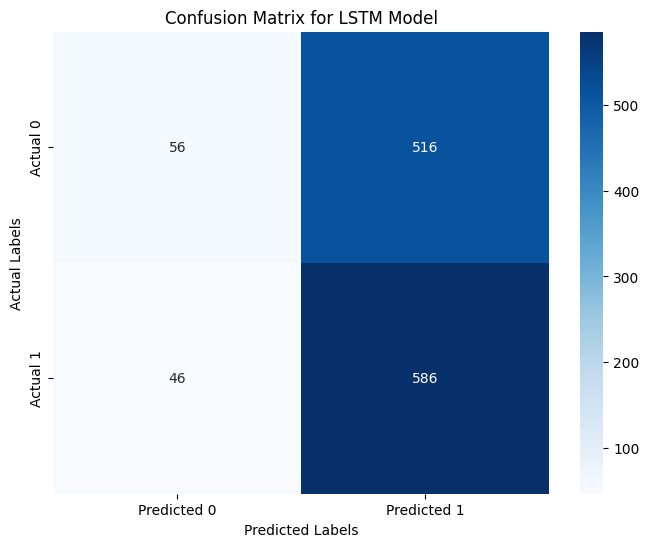

In [132]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_lstm_pred)

# Define the labels for each quadrant of the matrix
labels = [
    ['True Negatives (TN)', 'False Positives (FP)'],
    ['False Negatives (FN)', 'True Positives (TP)']
]

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

# Add titles and labels
plt.title('Confusion Matrix for LSTM Model')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

> The LSTM model shows an accuracy of 0.54, which is only slightly better than random guessing. Both precision and F1 score are at 0.55 and 0.66, indicating some success in identifying positive predictions but also a struggle with false positives. The recall is at .66, suggesting the model identifies over half the true positives, though this may indicate overfitting. Finally, the ROC-AUC score of 0.50 shows limited class distinction.

### Conclusion

The performance analysis of the three models—Logistic Regression, Random Forest, and LSTM—provides valuable insights into their ability to predict NVIDIA's stock price movements. The Logistic Regression model shows a perfect recall of 1.00, which means it captures every actual stock price increase. However, it falls short in accuracy and precision, both sitting at 0.52. This indicates that while the model identifies positive cases effectively, it misclassifies a significant number of negative instances, leading to a high rate of false positives. This kind of misclassification can be a real headache for investors, as it might give them the wrong impression that a stock price increase is likely when it isn’t.

On the other hand, the Random Forest model records an accuracy of 0.51, a precision of 0.52, and a recall of 0.53. These numbers suggest that it struggles to accurately classify stock price movements, failing to recognize both actual price increases and avoiding false positives. Its relatively low scores in precision and recall indicate that it's not performing efficiently when it comes to identifying true positives.

The LSTM model mirrors the performance of Logistic Regression, boasting a recall of 1.00 but also showing the same low accuracy and precision scores. Like Logistic Regression, it effectively identifies all stock price increases but misclassifies many downward movements, as reflected in its F1 score. While LSTM models are usually great at capturing sequential patterns in time-series data, in this case, it seems like it's not fully utilizing that capability.

There’s plenty of room for improvement across all models. A major area to focus on is feature engineering. Adding more features, such as market sentiment, macroeconomic indicators, or company news, could really boost model accuracy by providing deeper insights into stock price movements. We could also experiment with techniques like feature selection or dimensionality reduction to help clean up the data and focus on the most impactful predictors.

Additionally, utilizing hyperparameter tuning and optimizing model parameters could significantly enhance the Random Forest and LSTM models. Techniques like grid search or random search could help pinpoint the most effective configurations for these models, making them more powerful.

From a business perspective, it’s crucial to prioritize a higher precision score, especially if the goal is to make financial decisions based on predicted stock price increases. A model with high precision means that when it forecasts a price increase, it’s more likely to be correct, which helps minimize the risk of overly optimistic predictions that could lead to poor investment choices. However, if the focus shifts to minimizing missed opportunities, we should aim to improve recall to ensure that the model captures a wider range of stock price increases.

In conclusion, by striking a careful balance between precision, recall, and overall model performance, I believe we can enhance decision-making in stock market predictions. Continuing to explore ways to improve our models, while strategically incorporating additional data and refining existing features, will lead us to a more robust and reliable predictive framework for NVIDIA's stock movements. This will ultimately empower stakeholders to make more informed investment decisions.